In [1]:
import os
import pandas as pd


project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
data_path = os.path.join(project_root, 'data', 'AAPL_iv_merged.csv')

print("Reading from:", data_path)
df = pd.read_csv(data_path)
print("Total rows in file:", len(df))

df = df.dropna(subset=["implied_vol", "strike", "T", "type"])
print("After dropna:", len(df))

df = df[(df["implied_vol"] > 0.01) & (df["implied_vol"] < 3.0)]
print("After IV filter:", len(df))

df = df[(df["T"] > 0.001) & (df["T"] < 1.0)]
print("After T filter:", len(df))

print("Type values:", df["type"].unique())

df[["strike", "T", "type", "implied_vol"]].head()


Reading from: c:\Users\ritam\Options-volatility-forecasting\data\AAPL_iv_merged.csv
Total rows in file: 335
After dropna: 335
After IV filter: 335
After T filter: 335
Type values: [0 1]


,strike,T,type,implied_vol
0,110.0,0.016438,0,1.957031
1,140.0,0.016438,0,1.109379
2,145.0,0.016438,0,1.206059
3,150.0,0.016438,0,1.013677
4,160.0,0.016438,0,0.771487


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [3]:
X = df[["strike", "T", "type"]].values
y = df["implied_vol"].values


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split first
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale using only training data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train_raw)
X_test = scaler_X.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1))
y_test = scaler_y.transform(y_test_raw.reshape(-1, 1))

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1=nn.Linear(3,32)
        self.fc2=nn.Linear(32,16)
        self.fc3=nn.Linear(16,1)

    def forward(self,x):
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        return self.fc3(x);

In [6]:
model=Net()
optimizer=optim.Adam(model.parameters(),lr=0.01)
criterion=nn.MSELoss()


In [7]:
epochs=500

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs=model(X_train)
    loss=criterion(outputs,y_train)

    loss.backward()
    optimizer.step()

    if(epoch+1)%50==0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

Epoch 50/500, Loss: 0.073449
Epoch 100/500, Loss: 0.029740
Epoch 150/500, Loss: 0.027135
Epoch 200/500, Loss: 0.025764
Epoch 250/500, Loss: 0.025427
Epoch 300/500, Loss: 0.025493
Epoch 350/500, Loss: 0.024964
Epoch 400/500, Loss: 0.024690
Epoch 450/500, Loss: 0.024129
Epoch 500/500, Loss: 0.023746


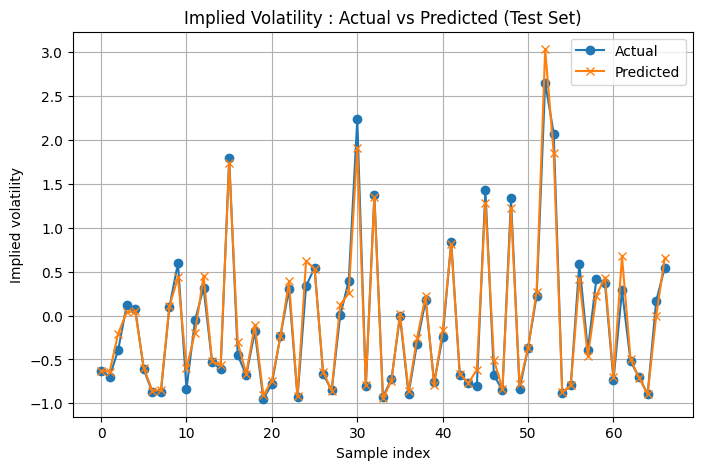

In [8]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze().numpy()
    actual = y_test.squeeze().numpy()

plt.figure(figsize=(8,5))
plt.plot(actual,label="Actual",marker='o')
plt.plot(predictions,label="Predicted",marker='x')
plt.title("Implied Volatility : Actual vs Predicted (Test Set)")
plt.xlabel("Sample index")
plt.ylabel("Implied volatility")
plt.legend()
plt.grid(True)
plt.show()